In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

In [ ]:
# Load dataset
df_solar = pd.read_csv('SolarPrediction.csv')

In [ ]:
# Display columns and check target
print("Columns:", df_solar.columns)
target_column = 'Radiation'  # Change if your target is named differently

Columns: Index(['UNIXTime', 'Data', 'Time', 'Radiation', 'Temperature', 'Pressure',
       'Humidity', 'WindDirection(Degrees)', 'Speed', 'TimeSunRise',
       'TimeSunSet'],
      dtype='object')


In [ ]:
# Drop irrelevant columns (e.g., timestamps)
df_solar = df_solar.select_dtypes(include=[np.number])  # Keep only numeric features

In [ ]:
# Handle missing values (if any)
df_solar = df_solar.dropna()

In [ ]:
# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_solar)

In [ ]:
# Select relevant features
features = df_solar[['Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed']]
target = df_solar[['Radiation']]

In [ ]:
# Define features (X) and target (y)
X_all = scaled_data[:, df_solar.columns != target_column]
y_all = scaled_data[:, df_solar.columns == target_column]
print(X_all.shape)
print(df_solar.columns)

(32686, 6)
Index(['UNIXTime', 'Radiation', 'Temperature', 'Pressure', 'Humidity',
       'WindDirection(Degrees)', 'Speed'],
      dtype='object')


In [ ]:
# Define the number of timesteps (e.g., use past 24 hours to predict next)
time_steps = 24

In [ ]:
# Function to create sequences
def create_sequences(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_all, y_all, time_steps)

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [ ]:
# Build CNN-LSTM model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/20
735/735 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.2262 - val_loss: 0.1562
Epoch 2/20
735/735 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1483 - val_loss: 0.1333
Epoch 3/20
735/735 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1306 - val_loss: 0.1313
Epoch 4/20
735/735 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1217 - val_loss: 0.1212
Epoch 5/20
735/735 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1192 - val_loss: 0.1152
Epoch 6/20
735/735 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1143 - val_loss: 0.1100
Epoch 7/20
735/735 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.1078 - val_loss: 0.1016
Epoch 8/20
735/735 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0964 - val_loss: 0.1024
Epoch 9/20
735/735 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0942 - val_loss: 0.1069
Epoch 10/20
735/735 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0894 - val_loss: 0.0970
Epoch 11/20
735/735 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0834 - val_loss: 0.1002
Epoch 12/20
735/735 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step

In [ ]:
# Predict
y_pred = model.predict(X_test)

205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
# Reverse scaling (optional, if you want to interpret actual values)
y_test_rescaled = scaler.inverse_transform(np.hstack((np.zeros((y_test.shape[0], X_all.shape[1])), y_test)))[:, -1]
y_pred_rescaled = scaler.inverse_transform(np.hstack((np.zeros((y_pred.shape[0], X_all.shape[1])), y_pred)))[:, -1]

In [ ]:
# Evaluate
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

In [ ]:
    # Display results
    print(f"✅ Mean Squared Error (MSE): {mse:.4f}")
    print(f"✅ Mean Absolute Error (MAE): {mae:.4f}")
    print(f"✅ Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"✅ R-squared (R²): {r2:.4f}")

✅ Mean Squared Error (MSE): 1.0333
✅ Mean Absolute Error (MAE): 0.5080
✅ Root Mean Squared Error (RMSE): 1.0165
✅ R-squared (R²): 0.9120


In [ ]:
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R² Score: {r2:.3f}")

RMSE: 1.017
MAE: 0.508
R² Score: 0.912


In [ ]:
# Calculate metrics in original units
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [ ]:
   # Display results
print(f"✅ Mean Squared Error (MSE): {mse:.4f}")
print(f"✅ Mean Absolute Error (MAE): {mae:.4f}")
print(f"✅ Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"✅ R-squared (R²): {r2:.4f}")

✅ Mean Squared Error (MSE): 0.0848
✅ Mean Absolute Error (MAE): 0.1455
✅ Root Mean Squared Error (RMSE): 0.2912
✅ R-squared (R²): 0.9120


In [ ]:
    # Calculate metrics in original units
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

In [ ]:
   # Display results
print(f"✅ Mean Squared Error (MSE): {mse:.4f}")
print(f"✅ Mean Absolute Error (MAE): {mae:.4f}")
print(f"✅ Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"✅ R-squared (R²): {r2:.4f}")

✅ Mean Squared Error (MSE): 1.0333
✅ Mean Absolute Error (MAE): 0.5080
✅ Root Mean Squared Error (RMSE): 1.0165
✅ R-squared (R²): 0.9120


In [ ]:
# Inverse transform from scaled to original units
# Create a temporary array with the shape of the original data and place the target values in the correct column
y_test_temp = np.zeros((y_test.shape[0], scaled_data.shape[1]))
y_test_temp[:, df_solar.columns.get_loc(target_column)] = y_test.flatten()
y_test_rescaled = scaler.inverse_transform(y_test_temp)[:, df_solar.columns.get_loc(target_column)]

y_pred_temp = np.zeros((y_pred.shape[0], scaled_data.shape[1]))
y_pred_temp[:, df_solar.columns.get_loc(target_column)] = y_pred.flatten()
y_pred_rescaled = scaler.inverse_transform(y_pred_temp)[:, df_solar.columns.get_loc(target_column)]

# Calculate metrics in original units
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

# Display results
print(f"✅ Mean Squared Error (MSE): {mse:.4f}")
print(f"✅ Mean Absolute Error (MAE): {mae:.4f}")
print(f"✅ Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"✅ R-squared (R²): {r2:.4f}")

✅ Mean Squared Error (MSE): 8464.5298
✅ Mean Absolute Error (MAE): 45.9808
✅ Root Mean Squared Error (RMSE): 92.0029
✅ R-squared (R²): 0.9120


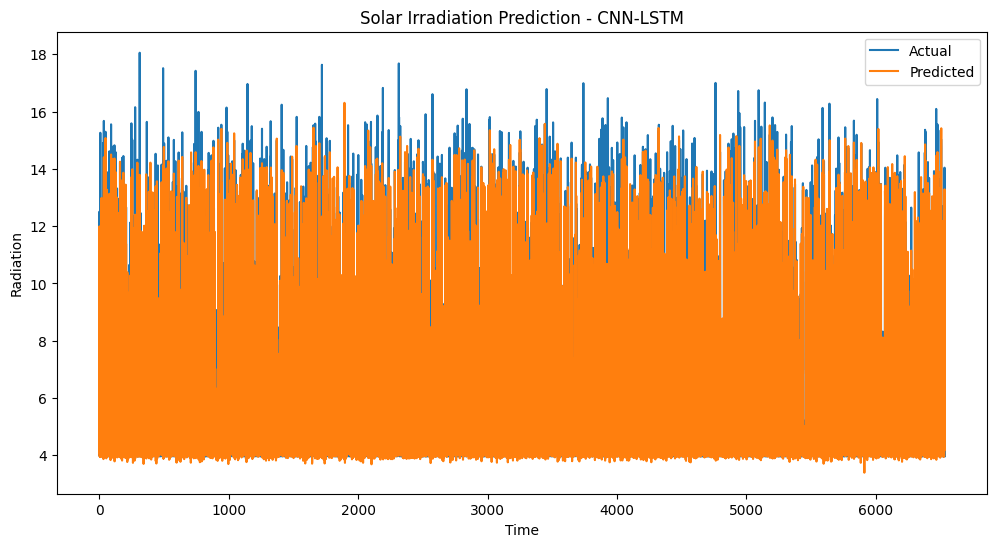

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted')
plt.title('Solar Irradiation Prediction - CNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Radiation')
plt.legend()
plt.show()